<a href="https://colab.research.google.com/github/noah-beniteznelson/recharge_deficit/blob/main/et_product_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assess the difference between ET products across Hahm et al. (2019) watersheds**

---

Created for *Patterns of Intra-Seasonal Groundwater Recharge Inferred from Streamflow and Explained by Vadose Zone Storage Deficits*.

**Authenticate Google Earth Engine (GEE) account and connect to project.** First time users sign-up [here](https://earthengine.google.com/new_signup/).

In [ ]:
import ee
ee.Authenticate() # Trigger the authentication flow.
ee.Initialize(project='rempe-hydro') # Initialize the library.

**Load GEE assets.**  Learn more about accessing GEE products using Python [here](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api).

In [ ]:
prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d")
pml = ee.ImageCollection("CAS/IGSNRR/PML/V2_v017")
openet = ee.ImageCollection("OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0")
modis = ee.ImageCollection("MODIS/061/MOD16A2")

**Mount Google Drive.** For running analyses in GoogleColab, save and  import datasets to/from selected folder in Google Drive.  To mount Drive, find the file name of the folder you wish to connect to.  By default, files are saved to user's "My Drive" dashboard.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)  # Change folder name here

Mounted at /content/drive


**Load packages.**

In [ ]:
!pip install -q geopandas
import geopandas as gpd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import datetime
import requests
import os
import json
import urllib
from shapely.geometry import Polygon
from datetime import timedelta
%config InlineBackend.figure_format = 'retina'

**Helper functions.**

In [ ]:
def extract_geometry(gage):
  """Retrieves the watershed basin geometry from the U.S. Geological Survey
  (USGS) National Water Information System as a Google Earth Engine (GEE)
  feature and GeoPandas GeoDataFrame.
  ----------
  Parameters
  ----------
  gage (:obj:`str`): USGS 8-number gage station ID

  ----------
  Returns
  ----------
  basin_poly (:obj:`feature`):  GEE polygon of basin.
  basin_geom (:obj:`gdf`):   GeoPandas GeoDataFrame containing the basin's geometry.
  """
  basin_geom = gpd.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage)

  # Check for MultiPolygon and simplify watershed bounds as needed
  if basin_geom.geometry[0].geom_type == 'MultiPolygon':
    print('\tMultiPolygon found, simplifying watershed boundary for gage '+gage)
    basin_geom = gpd.GeoDataFrame(geometry=gpd.GeoSeries(basin_geom.convex_hull))
  poly_coords = [item for item in basin_geom.geometry[0].exterior.coords]
  basin_poly = ee.Geometry.Polygon(coords=poly_coords)
  return basin_poly, basin_geom


def image_collection_to_df(collection,band,geom,start_date='1985-01-01',end_date='2050-01-01',scale=100,band_limit=5000):
  """Includes workaround for new GEE Python API limit on maximum number of bands for ee.ImageCollection.toBands() function.
  ----------
  Parameters
  ----------
  collection: GEE ImageCollection
  band (:obj:`str`): Target band for extraction
  geom: GEE polygon defining region
  start_date (:obj:`str`): Start of data retrieval (default='1985-01-01')
  end_date (:obj:`str`): End of data retrieval (default='2050-01-01')
  scale (:obj:`int`): Scale in meters for GEE reducer function (default=100)
  band_limit (:obj:`int`): Limit of ee.ImageCollection.toBands() function (default=5000)
  ----------
  Returns
  ----------
  df (:obj:`df`): Dataframe of band with datetime index
  ----------
  Notes
  ----------
  Data range of PRISM: 1981-01-01 to 2023-10-12 (daily total)
  Data range of PML: 2000-02-26 to 2020-12-26 (8-day average)
  Data range of MODIS: 2001-10-01 to 2023-09-22 (8-day total)
  Data range of OpenET: 2016-01-01 to 2022-12-01 (monthly total)

  """
  size = collection.filter(ee.Filter.date(start_date,end_date)).select(band).size().getInfo()

  # Check if ee.ImageCollection.toBands() function limit exceeded
  if size > band_limit:
    num_chunks = np.ceil(size/band_limit).astype(int)
    date = pd.to_datetime(start_date,format='%Y-%m-%d')

    for i in range(num_chunks):
      start_date = date + timedelta(days=i * band_limit)
      end_date = date + timedelta(days=(i+1) * band_limit - 1)
      asset = collection.filter(ee.Filter.date(start_date,end_date)).select(band).toBands()
      reducer_dict = asset.reduceRegion(reducer=ee.Reducer.mean(), geometry=geom, scale=500, maxPixels=1e12).getInfo()
      chunk = pd.DataFrame(list(reducer_dict.items()),columns=['date', band])
      df = pd.concat([df,chunk], ignore_index=True) if i != 0 else chunk

  # ImageCollection within ee.ImageCollection.toBands() function limits
  else:
    asset = collection.filter(ee.Filter.date(start_date,end_date)).select(band).toBands()
    reducer_dict = asset.reduceRegion(reducer=ee.Reducer.mean(), geometry=geom, scale=scale, maxPixels=1e12).getInfo()
    df = pd.DataFrame(list(reducer_dict.items()),columns=['date', band])

  # Format date column -> comment out if errors appear and assign index later
  # df['date'] = [item.replace('-', '_').split('_')[:-1] for item in df['date'].values]
  # df['date'] = [pd.to_datetime('-'.join(item[0:3])) for item in df['date'].values]
  # df.set_index('date',inplace=True)

  # Format date column for OpenET
  # df['date'] = pd.to_datetime([item.split('_')[1] for item in df['date'].values])
  # df.set_index('date',inplace=True)
  return df

**Gage list.**

In [ ]:
# Catchment attributes
path = "/content/drive/My Drive/recharge_deficit/"
df_attr = pd.read_csv(path + "catchment_attributes.csv")
df_attr.set_index('USGS Gage ID',inplace=True,drop=True)
df_attr.index = df_attr.index.astype('str')
gage_list = df_attr.sort_values(by='Storage sensitivity to winter precipitation (rho)',ascending=True).index

**Extract evapotranspiration products, precipitation at each gage.**  Takes approx. 15 minutes to run.

In [ ]:
start_date = '2000-01-01'
end_date = '2023-10-01'

for gage in gage_list:
  # Drainage area upstream of USGS gage as GEE polygon and geopandas DataFrame
  basin_poly, basin_geom = extract_geometry(gage)

  # PRISM total daily precipitation (mm/day)
  ppt = image_collection_to_df(prism,'ppt',basin_poly,start_date=start_date,end_date=end_date,scale=500)
  ppt['date'] = [item.replace('-', '_').split('_')[:-1] for item in ppt['date'].values]
  ppt['date'] = [pd.to_datetime('-'.join(item[0:3])) for item in ppt['date'].values]
  ppt.set_index('date',inplace=True)
  ppt = ppt.add_suffix('_%s'%gage)
  df_prism = ppt if gage==gage_list[0] else df_prism.join(ppt,how='outer')

  # PML average 8-day evapotranspiration (mm/day) upsampled to daily series
  for band in ['Ec','Ei','Es']:
    component = image_collection_to_df(pml,band,basin_poly,start_date=start_date,end_date=end_date,scale=500)
    component['date'] = [item.replace('-', '_').split('_')[:-1] for item in component['date'].values]
    component['date'] = [pd.to_datetime('-'.join(item[0:3])) for item in component['date'].values]
    component.set_index('date',inplace=True)
    et = component if band=='Ec' else et.join(component,rsuffix='drop')
  et['et'] = et[['Ec','Ei','Es']].sum(axis=1)
  et = pd.concat([et['et'], pd.Series([0], index=[et.index[0] - np.timedelta64(8,'D')])])
  et = pd.DataFrame(et.resample('D').bfill())
  et.rename(columns={0:'pml'},inplace=True)
  et = et.add_suffix('_%s'%gage)[1:]
  df_pml = et if gage==gage_list[0] else df_pml.join(et,how='outer')

  # MODIS total 8-day evapotranspiration (mm/8day) upsampled to daily series
  et = image_collection_to_df(modis,'ET',basin_poly,start_date=start_date,end_date=end_date,scale=500)
  et['date'] = [item.replace('-', '_').split('_')[:-1] for item in et['date'].values]
  et['date'] = [pd.to_datetime('-'.join(item[0:3])) for item in et['date'].values]
  et.set_index('date',inplace=True)
  et = pd.concat([et['ET'], pd.Series([0], index=[et.index[0] - np.timedelta64(8,'D')])])
  et = pd.DataFrame(et.resample('D').bfill()/8)
  et.rename(columns={0:'modis'},inplace=True)
  et = et.add_suffix('_%s'%gage)[1:]
  df_modis = et if gage==gage_list[0] else df_modis.join(et,how='outer')

  # OpenET total monthly evapotranspiration (mm/month) upsampled to daily series
  et = image_collection_to_df(openet,'et_ensemble_mad',basin_poly,start_date=start_date,end_date=end_date,scale=30)
  et['date'] = pd.to_datetime([item.split('_')[1] for item in et['date'].values])
  et.set_index('date',inplace=True)
  et = pd.concat([et['et_ensemble_mad'], pd.Series([0], index=[et.index[-1] + np.timedelta64(1,'M') + np.timedelta64(1,'D')])]).resample('D').first()
  et = pd.DataFrame(et.groupby(et.notna().cumsum(),group_keys=False).apply(lambda x: x/len(x.index))).ffill()[:-1]
  et.rename(columns={0:'openet'},inplace=True)
  et = et.add_suffix('_%s'%gage)
  df_openet = et if gage==gage_list[0] else df_openet.join(et,how='outer')

  # Sanity check
  print('Successfully extracted evapotranspiration, precipitation upstream of gage %s.'%(gage))

Successfully extracted evapotranspiration, precipitation upstream of gage 11475800.
Successfully extracted evapotranspiration, precipitation upstream of gage 11475560.
Successfully extracted evapotranspiration, precipitation upstream of gage 11469000.
Successfully extracted evapotranspiration, precipitation upstream of gage 11449500.
Successfully extracted evapotranspiration, precipitation upstream of gage 11379500.
Successfully extracted evapotranspiration, precipitation upstream of gage 11476600.
Successfully extracted evapotranspiration, precipitation upstream of gage 11172945.
Successfully extracted evapotranspiration, precipitation upstream of gage 11180960.
Successfully extracted evapotranspiration, precipitation upstream of gage 11180900.
Successfully extracted evapotranspiration, precipitation upstream of gage 11180825.
Successfully extracted evapotranspiration, precipitation upstream of gage 11176400.
Successfully extracted evapotranspiration, precipitation upstream of gage 11

**[OPTIONAL] Save extracted data to Google Drive.** Select file name, type (default: csv), and location in Drive

In [ ]:
# # Helper function to check if path already exists before saving DataFrame
# def check_path_write(df,filename,path):
#   path = path+filename
#   if os.path.exists(path)!=True:
#     df.to_csv(path)

# path = "/content/drive/My Drive/recharge_deficit/" # change path here
# check_path_write(df_prism,"PRISM_ppt.csv",path)
# check_path_write(df_pml,"PML_et.csv",path)
# check_path_write(df_modis,"MODIS_et.csv",path)
# check_path_write(df_openet,"OpenET_et.csv",path)

**Load datasets (if previously saved).**

In [ ]:
def quick_index(df):
  df.set_index('Unnamed: 0',inplace=True,drop=True)
  df.index=pd.to_datetime(df.index)
  return df

# Gage List
path = "/content/drive/My Drive/recharge_deficit/"
df_attr = pd.read_csv(path + "catchment_attributes.csv")
df_attr.set_index('USGS Gage ID',inplace=True,drop=True)
df_attr.index = df_attr.index.astype('str')
gage_list = df_attr.sort_values(by='Storage sensitivity to winter precipitation (rho)',ascending=True).index

# # GEE data
# df_pml = quick_index(pd.read_csv(path + "PML_et.csv"))
# df_modis = quick_index(pd.read_csv(path + "MODIS_et.csv"))
# df_openet = quick_index(pd.read_csv(path + "OpenET_et.csv"))
# df_et = df_pml.join([df_modis,df_openet],how='outer')

# # Catchment attributes
# df_attr = pd.read_csv(path + "catchment_attributes.csv")
# df_attr.set_index('USGS Gage ID',inplace=True,drop=True)
# df_attr.index = df_attr.index.astype('str')

**Plot timeseries of ET at Elder Creek.**

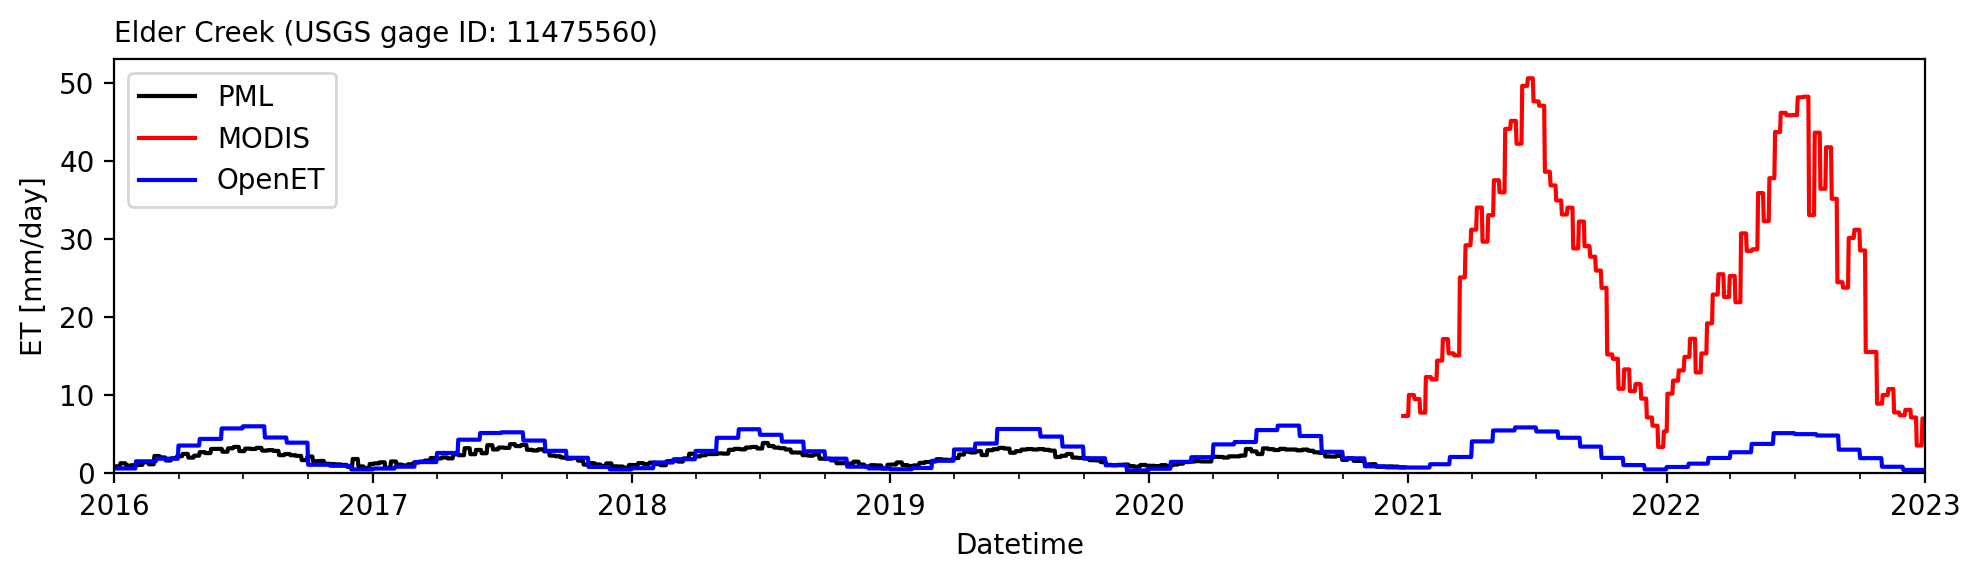

In [ ]:
gage = '11475560'
fig,ax = plt.subplots(figsize=(10,3))
df_et = df_et.loc["2016-01-01":"2023-01-01"]
df_et.plot(y='pml_%s'%gage,color='k',label="PML",ax=ax)
df_et.plot(y='modis_%s'%gage,color='r',label="MODIS",ax=ax)
df_et.plot(y='openet_%s'%gage,color='b',label="OpenET",ax=ax)
ax.set(xlabel = 'Datetime', ylabel = 'ET [mm/day]')
ax.set_title("Elder Creek (USGS gage ID: 11475560)",loc='left',fontsize=10)
ax.set_ylim(bottom=0)
fig.tight_layout()

**Plot PML vs. OpenET at each watershed.**

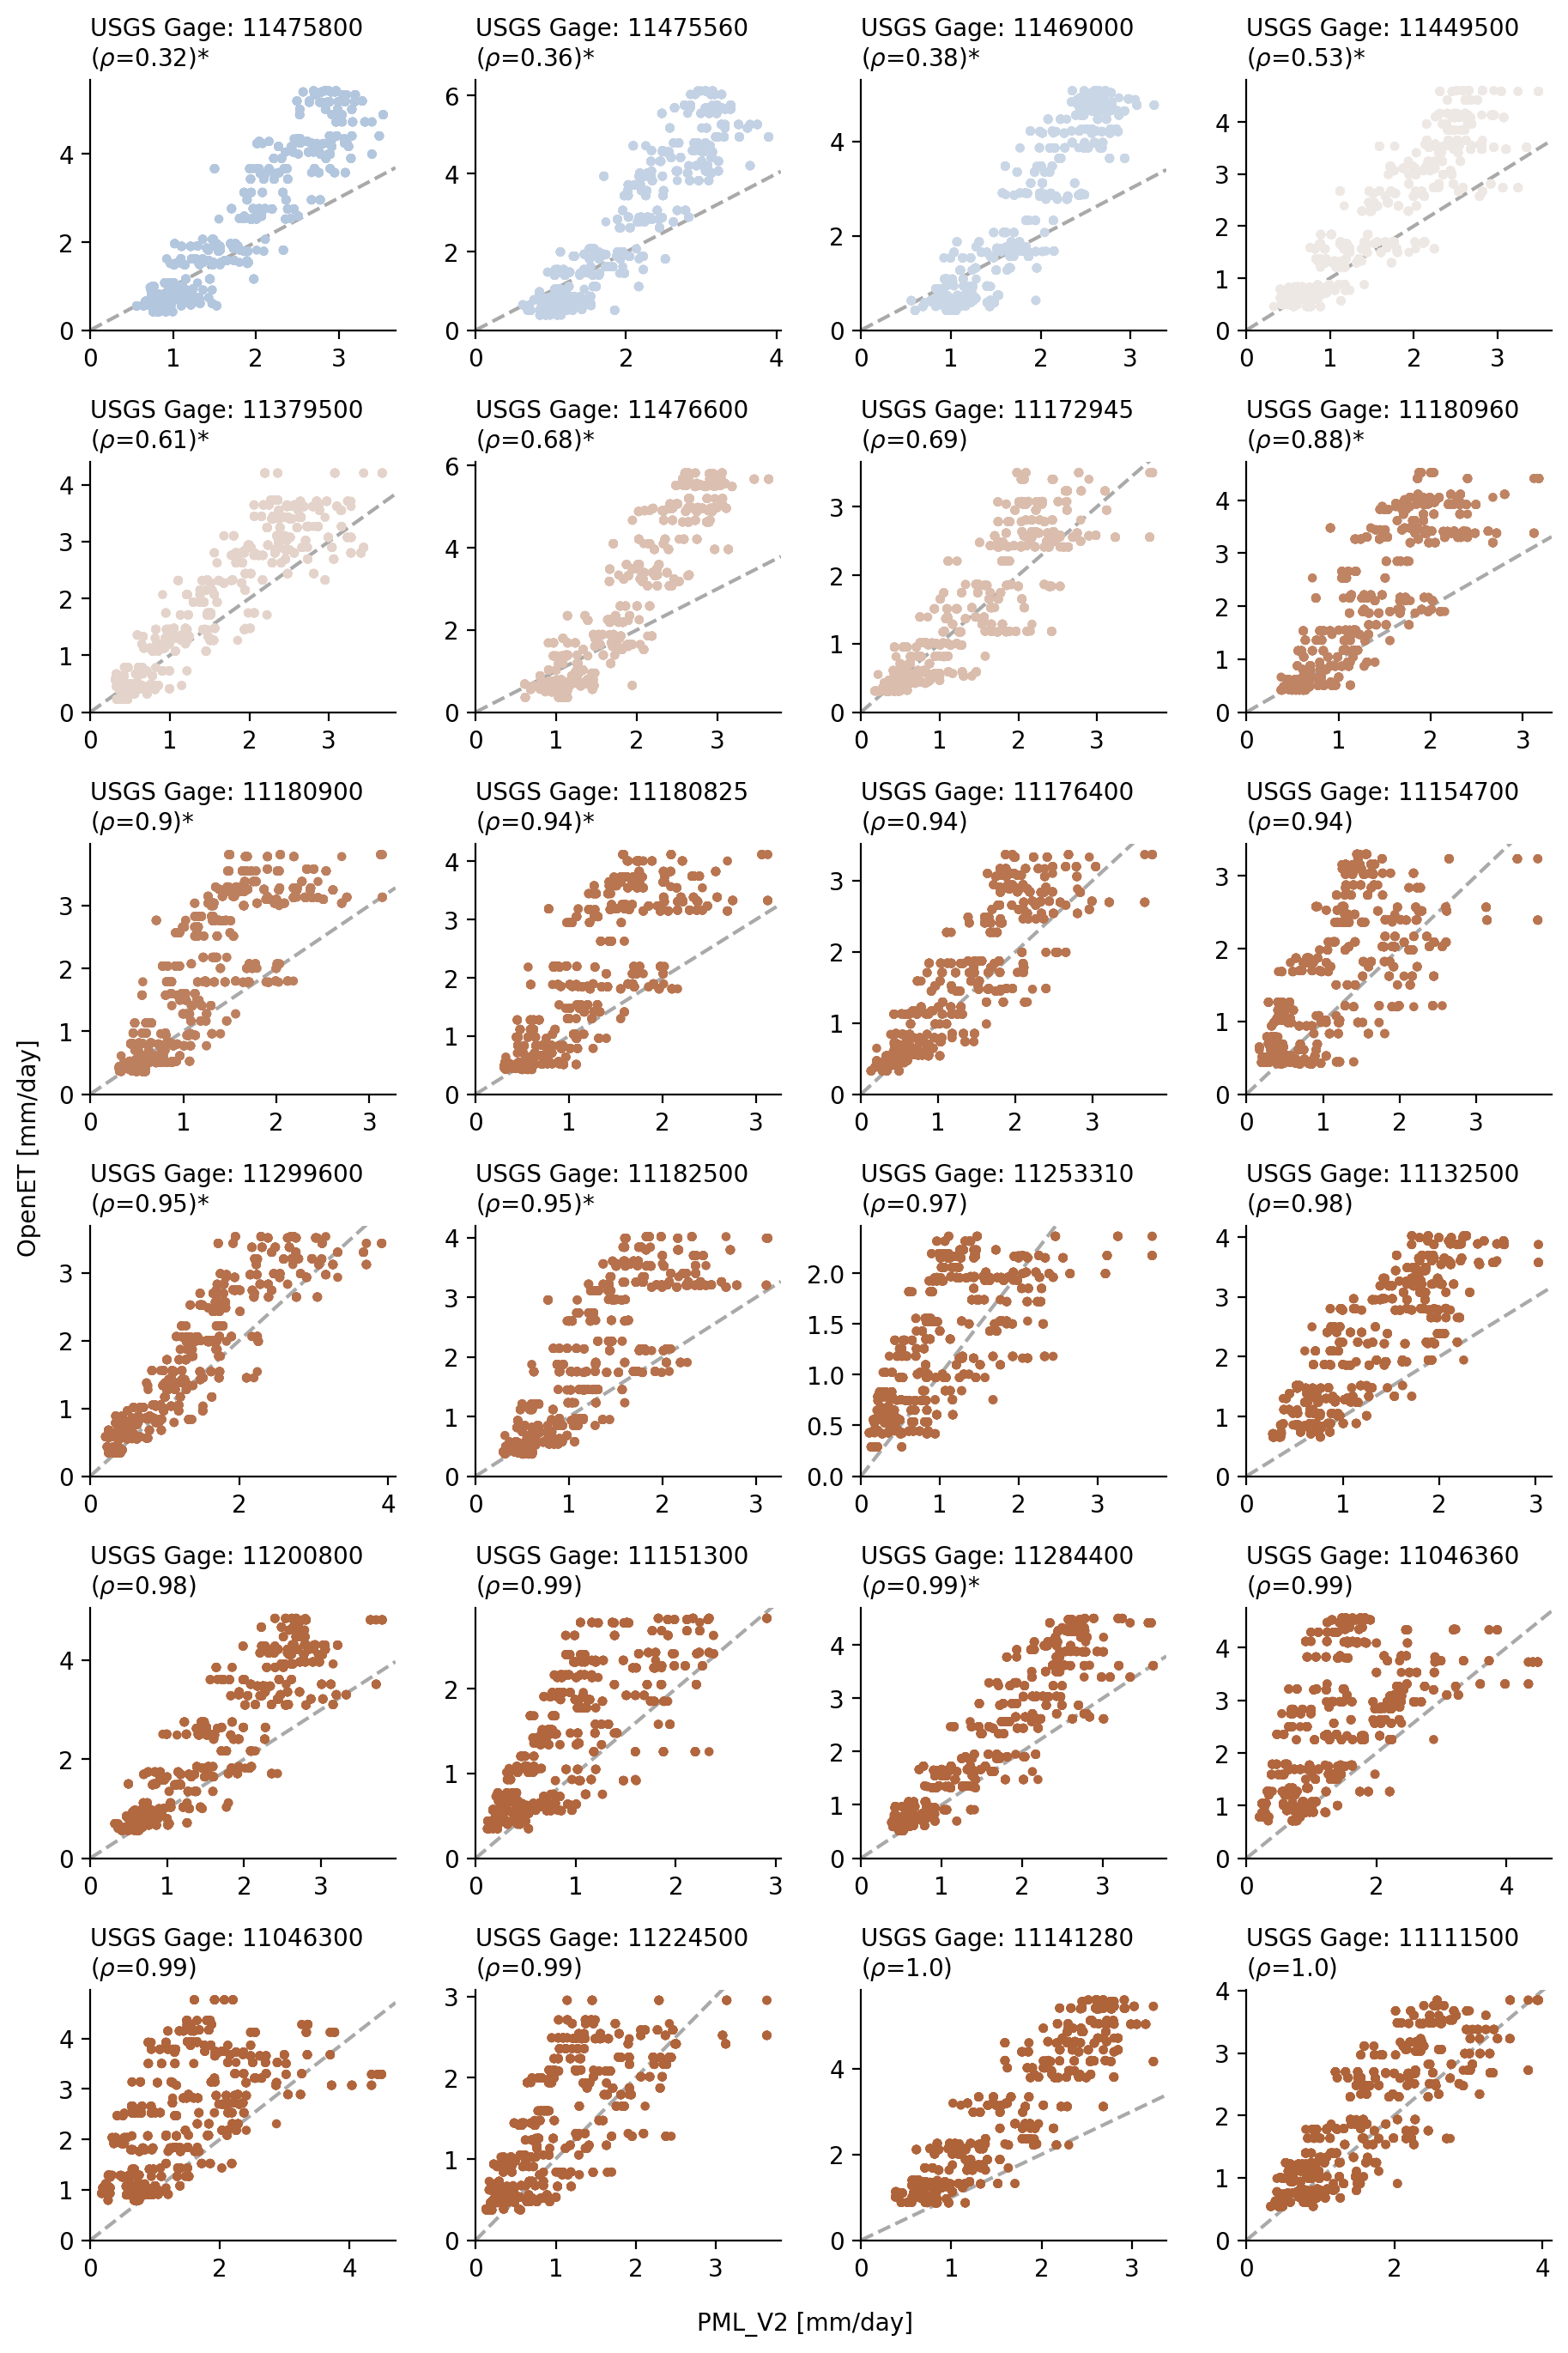

In [ ]:
# Analysis gages
analysis_gages = ['11475560', '11475800', '11469000', '11449500', '11379500', '11476600', '11180900', '11180960', '11180825', '11182500', '11299600', '11284400']

# Combine PML_V2 and OpenET evapotranspiration, drop missing data
df_et = df_pml.join(df_openet,how='outer').dropna()

# Plotting space, color map
fig, axs = plt.subplots(6,4,figsize=(9,13.5))
cmap = sns.diverging_palette(250, 30, l=50, as_cmap=True)

# Loop through gages
for gage,ax in zip(gage_list,axs.ravel()):
  rho = df_attr.loc[gage,"Storage sensitivity to winter precipitation (rho)"]
  title = "USGS Gage: %s\n"%gage+r"($\rho$=%s)*"%str(round(rho,2)) if gage in analysis_gages else "USGS Gage: %s\n"%gage+r"($\rho$=%s)"%str(round(rho,2))

  df_gage = df_et.filter(regex=".*%s"%gage).dropna()
  pml = df_gage["pml_%s"%gage]
  openet = df_gage["openet_%s"%gage]
  ax.scatter(pml,openet,s=8,c=[rho]*len(pml),cmap=cmap,vmin=0,vmax=1)
  ax.set_title(title,fontsize=10,loc='left')
  # 1:1 line
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([0,xmax],[0,xmax], label="1:1", c='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[0,xmax], ylim=[0,ymax])

# Label, figure handling
fig.text(0.5, -0.01, "PML_V2 [mm/day]", ha='center')
fig.text(-0.01, 0.5, "OpenET [mm/day]", va='center', rotation='vertical')
fig.tight_layout()
sns.despine()

**References.**

Daly, C., Halbleib, M., Smith, J.I., Gibson, W.P., Doggett, M.K., Taylor, G.H., Curtis, J., and Pasteris, P.A. 2008. Physiographically-sensitive mapping of temperature and precipitation across the conterminous United States. International Journal of Climatology, 28: 2031-2064

Daly, C., J.I. Smith, and K.V. Olson. 2015. Mapping atmospheric moisture climatologies across the conterminous United States. PloS ONE 10(10):e0141140. https://doi:10.1371/journal.pone.0141140.

Gan, R., Zhang, Y.Q., Shi, H., Yang, Y.T., Eamus, D., Cheng, L., Chiew, F.H.S., Yu, Q., 2018. Use of satellite leaf area index estimating evapotranspiration and gross assimilation for Australian ecosystems. Ecohydrology, https://doi:10.1002/eco.1974

Hahm, W. J., Dralle, D. N., Rempe, D. M., Bryk, A. B., Thompson, S. E., Dawson, T. E., & Dietrich, W. E. (2019). Low Subsurface Water Storage Capacity Relative to Annual Rainfall Decouples Mediterranean Plant Productivity and Water Use From Rainfall Variability. Geophysical Research Letters, 46(12), 6544–6553. https://doi.org/10.1029/2019GL083294

Melton, F., Huntington, J., Grimm, R., Herring, J., Hall, M., Rollison, D., Erickson, T., Allen, R., Anderson, M., Fisher, J., Kilic, A., Senay, G., volk, J., Hain, C., Johnson, L., Ruhoff, A., Blankenau, P., Bromley, M., Carrara, W., Daudert, B., Doherty, C., Dunkerly, C., Friedrichs, M., Guzman, A., Halverson, G., Hansen, J., Harding, J., Kang, Y., Ketchum, D., Minor, B., Morton, C., Revelle, P., Ortega-Salazar, S., Ott, T., Ozdogon, M., Schull, M., Wang, T., Yang, Y., Anderson, R., 2021. OpenET: Filling a Critical Data Gap in Water Management for the Western United States. Journal of the American Water Resources Association, 2021 Nov 2. doi:10.1111/1752-1688.12956

Zhang, Y., Peña-Arancibia, J.L., McVicar, T.R., Chiew, F.H.S., Vaze, J., Liu, C., Lu, X., Zheng, H., Wang, Y., Liu, Y.Y., Miralles, D.G., Pan, M., 2016. Multi-decadal trends in global terrestrial evapotranspiration and its components. Sci. Rep. 6, 19124. https://doi:10.1038/srep19124

Zhang, Y., Kong, D., Gan, R., Chiew, F.H.S., McVicar, T.R., Zhang, Q., and Yang, Y., 2019. Coupled estimation of 500m and 8-day resolution global evapotranspiration and gross primary production in 2002-2017. Remote Sens. Environ. 222, 165-182, https://doi:10.1016/j.rse.2018.12.031